In [1]:
# =========================
# 1) Importaciones y setup
# =========================
from __future__ import annotations
import os
import io
import re
import json
import zipfile
import math
import urllib.request
from typing import Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

In [2]:
# XGBoost
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
DATA_DIR = os.path.join(os.getcwd(), "data")
MODELS_DIR = os.path.join(os.getcwd(), "models")
REPORTS_DIR = os.path.join(os.getcwd(), "reports")
for d in (DATA_DIR, MODELS_DIR, REPORTS_DIR):
    os.makedirs(d, exist_ok=True)

UCI_ZIP_URL = (
    "https://archive.ics.uci.edu/static/public/601/ai4i%2B2020%2Bpredictive%2Bmaintenance%2Bdataset.zip"
)
CSV_EXPECTED = os.path.join(DATA_DIR, "ai4i2020.csv")

In [4]:
# ==========================================
# 2) Utilidades: descarga y carga del dataset
# ==========================================

def _download_and_extract_ai4i(dest_csv: str = CSV_EXPECTED) -> str:
    """Descarga el ZIP oficial de UCI y extrae ai4i2020.csv en data/.
    Retorna la ruta del CSV.
    """
    if os.path.exists(dest_csv):
        return dest_csv

    print("Descargando AI4I 2020 desde UCI...")
    with urllib.request.urlopen(UCI_ZIP_URL) as resp:
        zip_bytes = resp.read()
    zf = zipfile.ZipFile(io.BytesIO(zip_bytes))

    # Buscar un archivo .csv dentro del ZIP
    csv_name = None
    for name in zf.namelist():
        if name.lower().endswith(".csv"):
            csv_name = name
            break
    if csv_name is None:
        raise FileNotFoundError("No se encontró un .csv dentro del ZIP de UCI")

    with zf.open(csv_name) as f_in, open(dest_csv, "wb") as f_out:
        f_out.write(f_in.read())

    print(f"CSV extraído en: {dest_csv}")
    return dest_csv


def _clean_col(col: str) -> str:
    """Normaliza nombres de columnas a snake_case y elimina unidades entre corchetes."""
    col = col.strip()
    # Quitar unidades entre corchetes, ej.: "Air temperature [K]" -> "Air temperature"
    col = re.sub(r"\s*\[[^\]]*\]", "", col)
    col = col.lower().replace(" ", "_")
    col = re.sub(r"[^0-9a-z_]+", "", col)  # quitar caracteres raros
    return col


def load_ai4i_dataframe(path: str | None = None) -> pd.DataFrame:
    """Carga y limpia el dataset AI4I 2020, devolviendo un DataFrame listo para EDA/modelado."""
    if path is None:
        path = CSV_EXPECTED
        if not os.path.exists(path):
            path = _download_and_extract_ai4i(CSV_EXPECTED)

    df = pd.read_csv(path)
    # Normalizar nombres de columnas
    df.columns = [_clean_col(c) for c in df.columns]

    # Tipos: forzar categóricos útiles
    if "type" in df.columns:
        df["type"] = df["type"].astype("category")
    if "product_id" in df.columns:
        df["product_id"] = df["product_id"].astype("category")

    # Crear features derivados útiles
    # power_w = torque * (2*pi*rotational_speed/60)
    if set(["torque", "rotational_speed"]).issubset(df.columns):
        df["angular_speed_rad_s"] = 2 * math.pi * df["rotational_speed"] / 60.0
        df["power_w"] = df["torque"] * df["angular_speed_rad_s"]

    return df

In [5]:
# ==========================
# 3) Análisis exploratorio
# ==========================

def quick_eda(df: pd.DataFrame, sample_pairplot: int = 600) -> None:
    """EDA básico: info, target balance, correlaciones y pairplot muestreado."""
    print("\nVista general:")
    print(df.head())
    print("\nTipos:")
    print(df.dtypes)

    # Columnas objetivo (flags de falla) y target principal
    target_col = "machine_failure" if "machine_failure" in df.columns else None
    failure_flags = [c for c in ["twf", "hdf", "pwf", "osf", "rnf"] if c in df.columns]

    if target_col:
        print("\nBalance de clases (machine_failure):")
        print(df[target_col].value_counts())
        ax = df[target_col].value_counts().plot(kind="bar")
        ax.set_title("Balance de clases — machine_failure")
        ax.set_xlabel("Clase")
        ax.set_ylabel("Conteo")
        plt.show()

    # Matriz de correlación numérica
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        corr = df[num_cols].corr(numeric_only=True)
        plt.figure()
        sns.heatmap(corr, annot=False)
        plt.title("Matriz de correlación (numérica)")
        plt.tight_layout()
        plt.show()

    # Pairplot muestreado para evitar sobrecarga
    if target_col:
        try:
            sample_df = df.sample(n=min(sample_pairplot, len(df)), random_state=RANDOM_SEED)
            cols_pp = [c for c in [
                "air_temperature", "process_temperature", "rotational_speed",
                "torque", "tool_wear", "power_w", target_col
            ] if c in sample_df.columns]
            if len(cols_pp) >= 3:
                sns.pairplot(sample_df[cols_pp], hue=target_col, diag_kind="hist")
                plt.suptitle("Pairplot (muestra)", y=1.02)
                plt.show()
        except Exception as e:
            print(f"Pairplot omitido: {e}")

In [6]:
# =====================================
# 4) Preprocesamiento y particionado
# =====================================

def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, ColumnTransformer]:
    """Construye X, y; codifica categóricos y devuelve los sets de train/test y el preprocesador."""
    assert "machine_failure" in df.columns, "No se encontró la columna objetivo 'machine_failure'"

    y = df["machine_failure"].astype(int)

    # Selección de features
    feature_candidates = [
        "air_temperature", "process_temperature", "rotational_speed",
        "torque", "tool_wear", "power_w", "type"
    ]
    X = df[[c for c in feature_candidates if c in df.columns]].copy()

    num_cols = [c for c in X.columns if X[c].dtype.kind in "if" and c != "machine_failure"]
    cat_cols = [c for c in X.columns if str(X[c].dtype) == "category" or X[c].dtype == object]

    # Ordinal para 'type' L<M<H si existe
    ordinal_maps = []
    if "type" in cat_cols:
        ordinal_maps.append(["type", ["L", "M", "H"]])

    transformers = []
    if num_cols:
        transformers.append(("num", StandardScaler(with_mean=False), num_cols))
    if cat_cols:
        if ordinal_maps:
            # Construir OrdinalEncoder con categorías definidas para columnas específicas
            cats = []
            for c in cat_cols:
                if c == "type":
                    cats.append(["L", "M", "H"])  # ordenado
                else:
                    cats.append("auto")
            enc = OrdinalEncoder(categories=cats, handle_unknown="use_encoded_value", unknown_value=-1)
        else:
            enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        transformers.append(("cat", enc, cat_cols))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    return X_train, y_train, X_test, y_test, preprocessor

In [7]:
# =============================
# 5) Modelado y evaluación
# =============================

def evaluate_binary(y_true, y_pred, y_proba) -> Dict[str, float]:
    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    }
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true, y_proba))
    except Exception:
        metrics["roc_auc"] = float("nan")
    return metrics


def train_random_forest(X_train, y_train, preprocessor: ColumnTransformer) -> Pipeline:
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", rf)
    ])
    pipe.fit(X_train, y_train)
    return pipe


def train_xgboost(X_train, y_train, preprocessor: ColumnTransformer) -> Pipeline | None:
    if not _HAS_XGB:
        print("XGBoost no disponible. Omite este modelo o instala xgboost.")
        return None

    # Calcular scale_pos_weight = neg/pos
    pos = int(y_train.sum())
    neg = int(len(y_train) - pos)
    spw = max(1.0, neg / max(1, pos))

    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        scale_pos_weight=spw,
        n_jobs=-1,
    )
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", xgb)
    ])
    pipe.fit(X_train, y_train)
    return pipe


def plot_and_report(model: Pipeline, X_test: pd.DataFrame, y_test: pd.Series, title: str, save_prefix: str) -> Dict[str, float]:
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    m = evaluate_binary(y_test, y_pred, y_proba)
    print(f"\n==== {title} ====")
    print(json.dumps(m, indent=2))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # ROC
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC — {title}")
    plt.show()

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matriz de confusión — {title}")
    plt.show()

    # Guardar métricas
    metrics_path = os.path.join(REPORTS_DIR, f"{save_prefix}_metrics.json")
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(m, f, indent=2)
    print(f"Métricas guardadas en: {metrics_path}")

    return m

In [8]:
# =============================
# 6) Importancias de variables
# =============================

def feature_importances(model: Pipeline, feature_names: list[str]) -> pd.DataFrame:
    """Extrae importancias desde RandomForest o XGBoost."""
    clf = model.named_steps.get("clf")
    imp = None
    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
    elif hasattr(clf, "get_booster"):
        imp = clf.get_booster().get_score(importance_type="weight")
        # Para XGB, devolver en formato DataFrame
        if isinstance(imp, dict):
            return pd.DataFrame({"feature": list(imp.keys()), "importance": list(imp.values())}).sort_values("importance", ascending=False)
    else:
        raise ValueError("El clasificador no expone importancias de característica")

    # Recuperar nombres transformados desde el preprocesador
    prep = model.named_steps["prep"]
    out_names = []
    for name, trans, cols in prep.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            out_names.extend(list(trans.get_feature_names_out(cols)))
        else:
            out_names.extend(list(cols))

    if imp is not None and not isinstance(imp, dict):
        df_imp = pd.DataFrame({"feature": out_names, "importance": imp})
        df_imp = df_imp.sort_values("importance", ascending=False)
        return df_imp

    raise ValueError("No se pudieron obtener importancias de características")

Descargando AI4I 2020 desde UCI...
CSV extraído en: /content/data/ai4i2020.csv

Vista general:
   udi product_id type  air_temperature  process_temperature  \
0    1     M14860    M            298.1                308.6   
1    2     L47181    L            298.2                308.7   
2    3     L47182    L            298.1                308.5   
3    4     L47183    L            298.2                308.6   
4    5     L47184    L            298.2                308.7   

   rotational_speed  torque  tool_wear  machine_failure  twf  hdf  pwf  osf  \
0              1551    42.8          0                0    0    0    0    0   
1              1408    46.3          3                0    0    0    0    0   
2              1498    49.4          5                0    0    0    0    0   
3              1433    39.5          7                0    0    0    0    0   
4              1408    40.0          9                0    0    0    0    0   

   rnf  angular_speed_rad_s      power_w  
0 

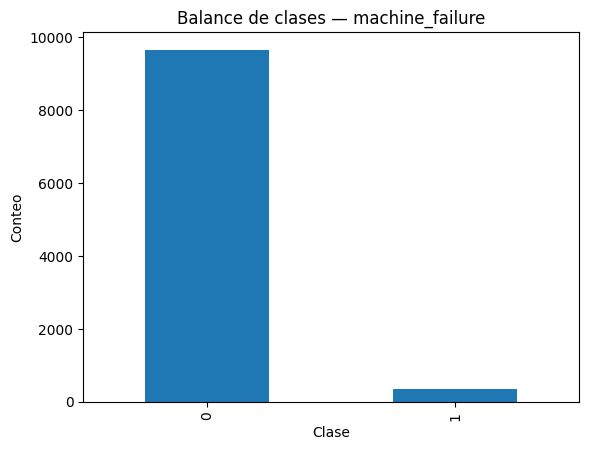

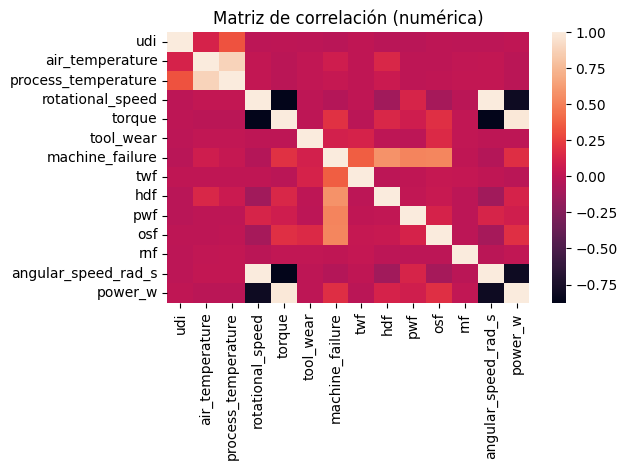

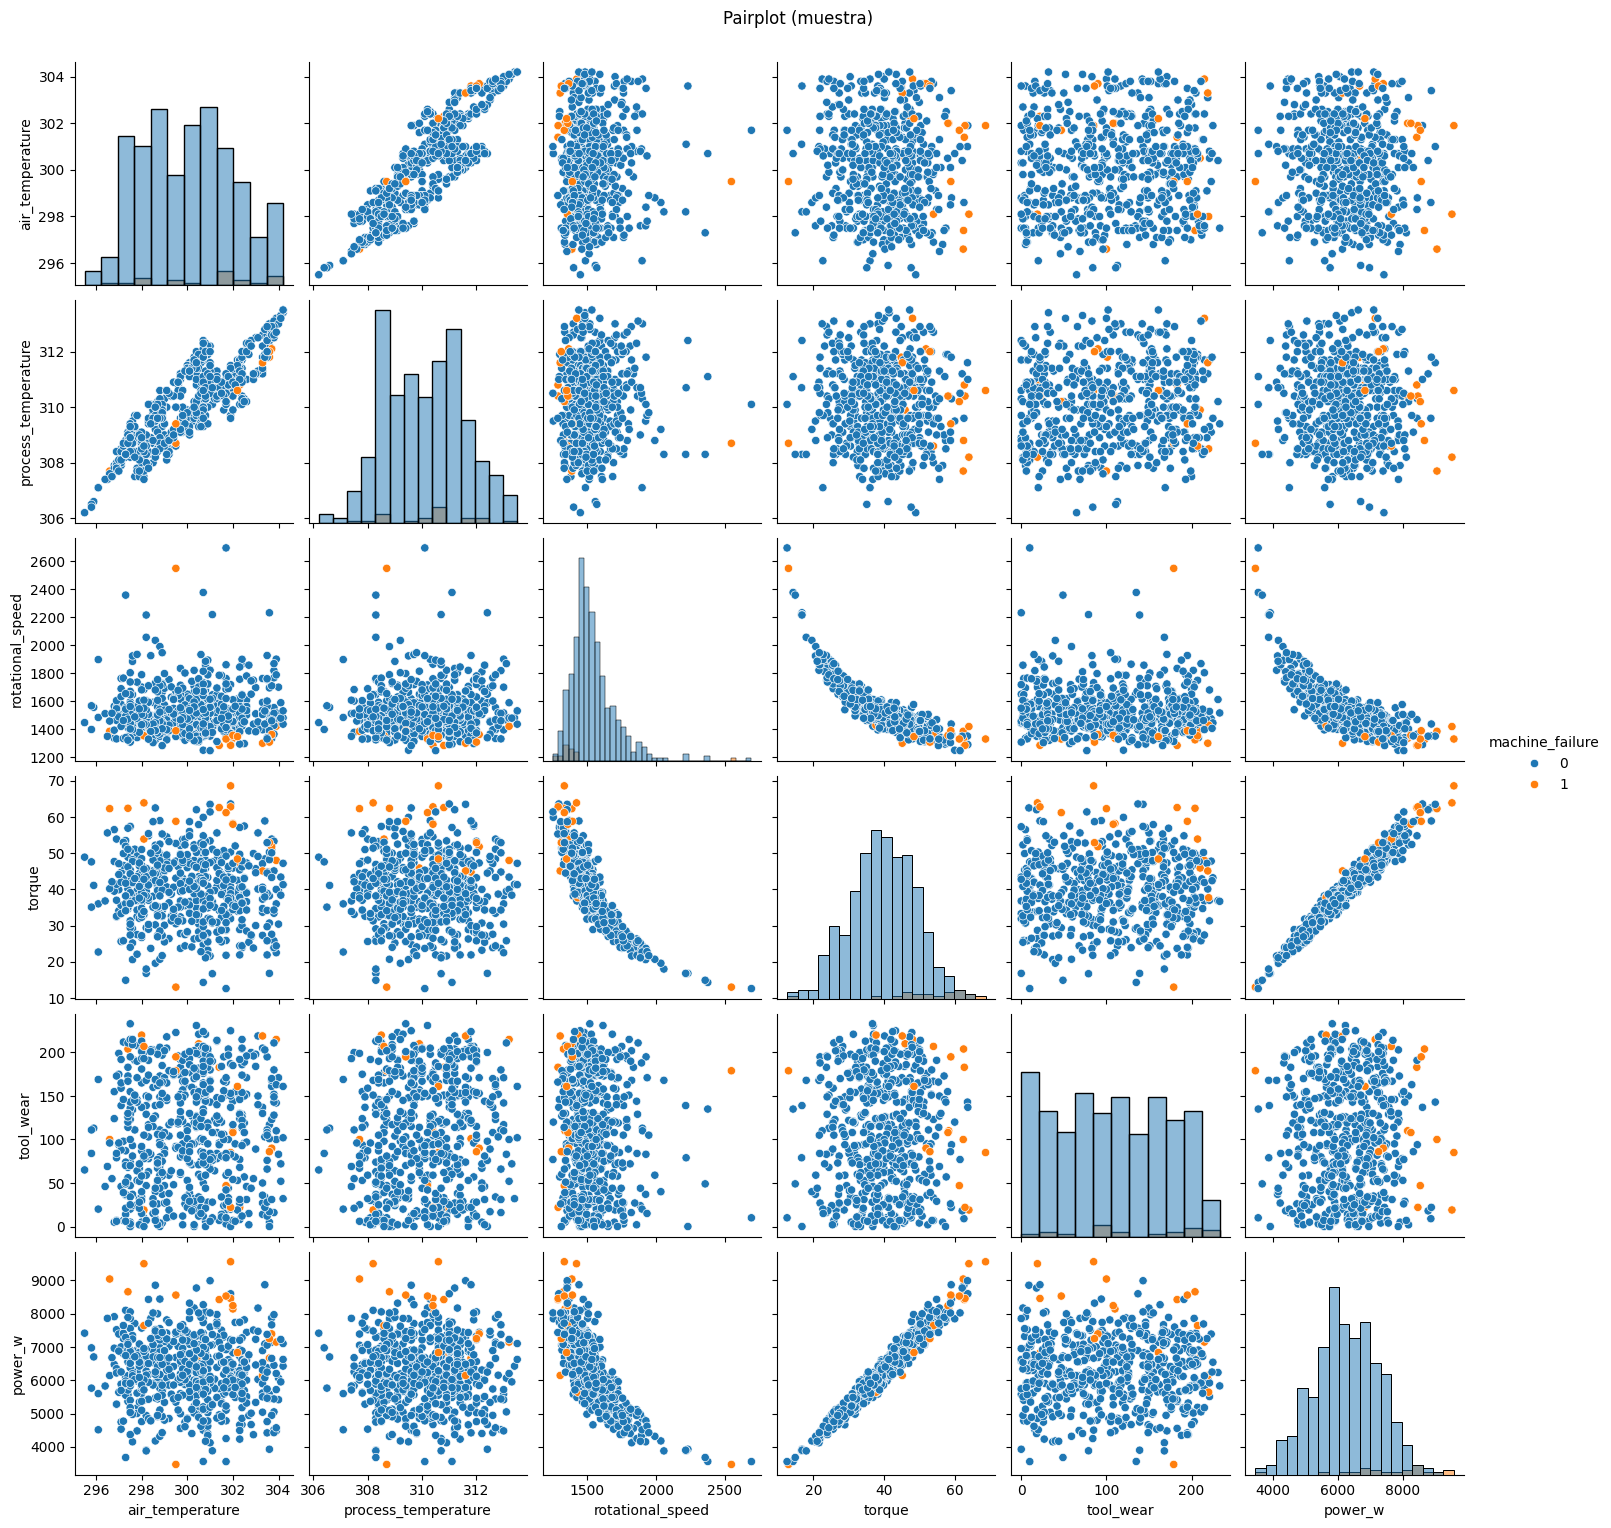


==== RandomForest (balanced) ====
{
  "accuracy": 0.982,
  "precision": 0.8809523809523809,
  "recall": 0.5441176470588235,
  "f1": 0.6727272727272727,
  "roc_auc": 0.9661163378394837
}

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.88      0.54      0.67        68

    accuracy                           0.98      2000
   macro avg       0.93      0.77      0.83      2000
weighted avg       0.98      0.98      0.98      2000



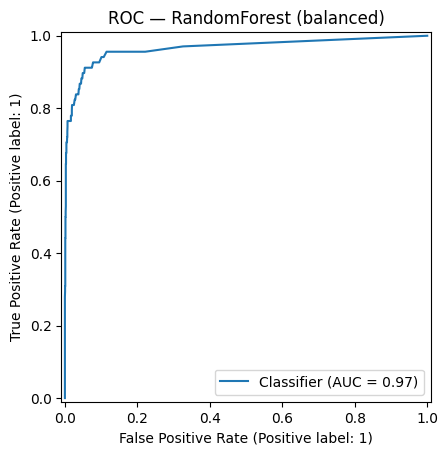

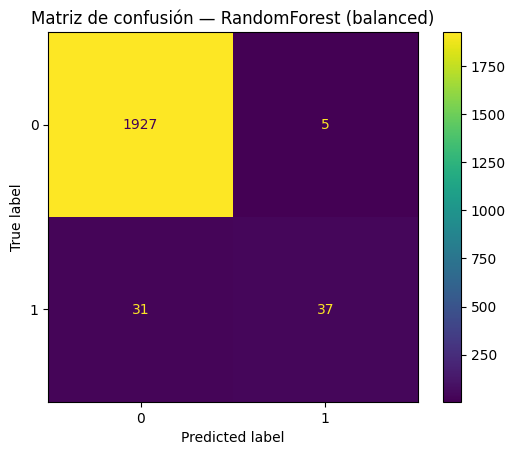

Métricas guardadas en: /content/reports/rf_metrics.json
Modelo RF guardado en: /content/models/rf_ai4i.joblib

==== XGBoost (scale_pos_weight) ====
{
  "accuracy": 0.987,
  "precision": 0.8181818181818182,
  "recall": 0.7941176470588235,
  "f1": 0.8059701492537313,
  "roc_auc": 0.9755282547801729
}

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.82      0.79      0.81        68

    accuracy                           0.99      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.99      0.99      0.99      2000



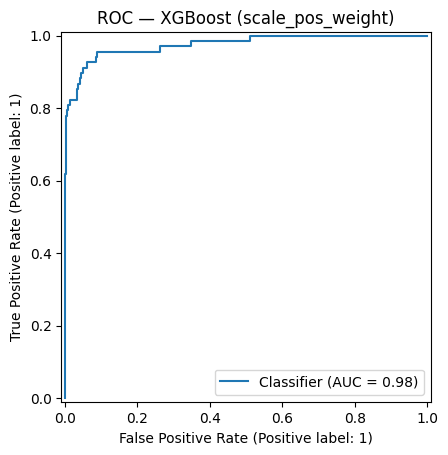

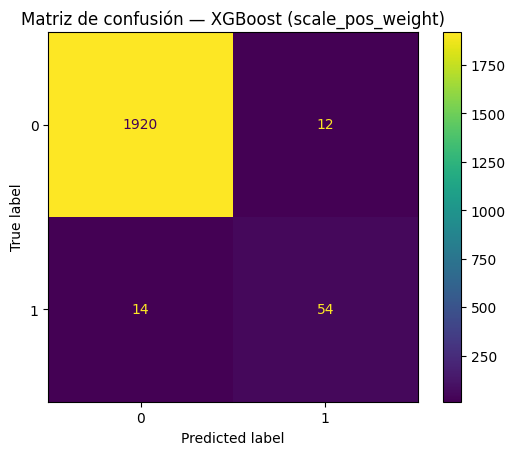

Métricas guardadas en: /content/reports/xgb_metrics.json
Modelo XGB guardado en: /content/models/xgb_ai4i.joblib


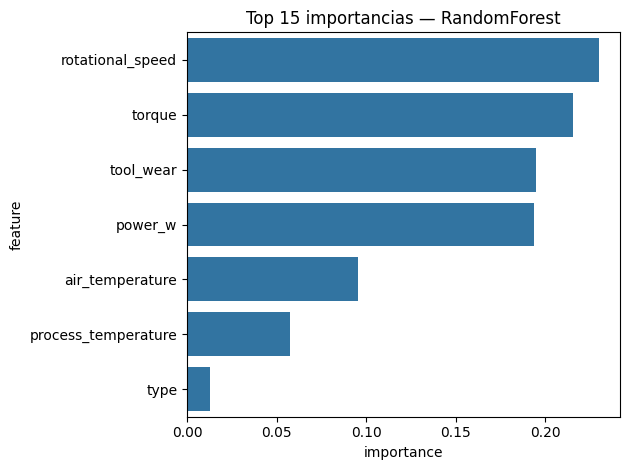


Pipeline completo.


In [9]:
# =============================
# 7) Main (ejecución end-to-end)
# =============================
if __name__ == "__main__":
    # 7.1 Carga y EDA
    df = load_ai4i_dataframe()
    quick_eda(df)

    # 7.2 Split y preprocesamiento
    X_train, y_train, X_test, y_test, preprocessor = split_data(df)

    # 7.3 Random Forest
    rf_pipe = train_random_forest(X_train, y_train, preprocessor)
    rf_metrics = plot_and_report(rf_pipe, X_test, y_test, title="RandomForest (balanced)", save_prefix="rf")

    # Guardar modelo RF
    rf_path = os.path.join(MODELS_DIR, "rf_ai4i.joblib")
    dump(rf_pipe, rf_path)
    print(f"Modelo RF guardado en: {rf_path}")

    # 7.4 XGBoost
    if _HAS_XGB:
        xgb_pipe = train_xgboost(X_train, y_train, preprocessor)
        if xgb_pipe is not None:
            xgb_metrics = plot_and_report(xgb_pipe, X_test, y_test, title="XGBoost (scale_pos_weight)", save_prefix="xgb")
            xgb_path = os.path.join(MODELS_DIR, "xgb_ai4i.joblib")
            dump(xgb_pipe, xgb_path)
            print(f"Modelo XGB guardado en: {xgb_path}")

            # Importancias
    try:
        imp_df = feature_importances(rf_pipe, feature_names=[])
        plt.figure()
        sns.barplot(data=imp_df.head(15), x="importance", y="feature")
        plt.title("Top 15 importancias — RandomForest")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Importancias no disponibles: {e}")